# CLEAN BUILD FROM SCRATCH EFFNET-UNET b7 on patches

In [1]:
CURRENT_FOLD = 1

# imports

In [2]:
import random

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
from customeunet.utils import *
from customeunet.layers import *
from customeunet.efficientnet import *
from customeunet.efficientunet import *

# model

In [4]:
def AUXhead(in_channels, mid_channels, out_channels, upsample=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=upsample, mode='bilinear')
    )

In [5]:
class EfficientUnetAUX(nn.Module):
    def __init__(self, backbone, n_classes=2, concat_input=True):
        super().__init__()
        
        self.backbone = backbone
        
        self.encoder = EfficientNet.encoder(backbone, pretrained=True)
        self.model = EfficientUnet(self.encoder, out_channels=n_classes, concat_input=True)
        
        self.aux3head = AUXhead(128, 256, n_classes, 4)
        self.aux2head = AUXhead(256, 256, n_classes, 8)
        
    def forward(self, x):
        data = self.model(x)
        aux2 = self.aux2head(data['aux2'])
        aux3 = self.aux3head(data['aux3'])
        out = {
            'logits': data['x'],
            'aux2': aux2,
            'aux3': aux3,
        }
        return out

In [6]:
model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6)

# data

In [7]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

## data 512

In [8]:
# img256 = cv.imread('./../data/train_data_eunet_patches/256/train/10044_0000.png')
# img512 = cv.imread('./../data/train_data_eunet_patches/512/train/10044_0000.png')

In [9]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_data_eunet_patches/512/train/'
TRAIN_MASKS_DIR = './../data/train_data_eunet_patches/512/masks/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022
CURRENT_FOLD = 1

SPATIAL_SIZE = 512 # размер патча


In [10]:
train_df = pd.read_csv(TRAIN_CSV)

In [11]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [12]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [13]:
def make_512_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('/train/', '/masks/')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [14]:
train_df_512 = make_512_dataset(train_df)
print(train_df_512.shape)
train_df_512.head()

(2895, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
1,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
2,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
3,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
4,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4


In [15]:
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

In [16]:
# train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.HueSaturationValue(p=0.2),
#     A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(0.05, 0.6),rotate_limit=90, p=0.5),
#     A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#     A.GridDistortion(p=0.25),
#     A.Blur(blur_limit=5, p=0.1),
#     A.GaussNoise(var_limit=(20, 100), p=0.2),
#     A.ChannelDropout(p=0.05),
#     A.RandomGamma(p=0.1),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(mean=mean, std=std, 
#                 max_pixel_value=255, always_apply=True),
#     albumentations.pytorch.ToTensorV2()
# ], p=1)

In [17]:
test_transform = A.Compose([
    A.Normalize(mean=mean, std=std, 
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [19]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

# VALID

In [41]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [21]:
device = 'cuda:1'
DEVICE = device

In [22]:
model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6).to(device)

In [96]:
model.load_state_dict(torch.load('./checkpoint_fold_1/effunet_ep_150_dice_00000nan_loss_0.066483.pt', 
                                 map_location=device))

<All keys matched successfully>

In [97]:
_ = model.eval()

In [98]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [99]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        out = self.model(x)
        prob = F.softmax(out['logits'], dim=1)
        return prob

In [100]:
predictor = Predictor(model)

In [101]:
train_df[train_df['fold'] == 1].head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
10,10912,prostate,HPA,3000,3000,0.4,4,1147323 50 1150316 59 1153309 68 1156303 76 11...,60.0,Male,1.0
15,11448,spleen,HPA,3000,3000,0.4,4,3450282 28 3453278 33 3456272 53 3459271 56 34...,21.0,Female,1.0
16,11497,kidney,HPA,3000,3000,0.4,4,940436 51 943430 65 946427 76 949423 89 952417...,41.0,Female,1.0
22,1184,prostate,HPA,3000,3000,0.4,4,1916384 12 1919383 15 1922378 26 1925376 29 19...,60.0,Male,1.0
26,1220,lung,HPA,3000,3000,0.4,4,1429797 16 1432793 21 1435791 23 1438789 27 14...,59.0,Male,1.0


In [102]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4):
    THRESHOLD = 0.5
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    gt_mask  = np.load('./../data/train_masks/{}.npy'.format(id))
    
    scale_factor = 0.5 * (pixel_size / 0.4)
    image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
#     image_rot = image.copy()
    masks = []
    for _ in range(1):
#         image_rot = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
        
        image_tensor = test_transform(image=image)['image']

        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            infer_result = sliding_window_inference(
                image_tensor, roi_size=(512, 512), sw_batch_size=2, predictor=predictor, 
                overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
                padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
            )

        organ_id = ORGAN2ID[organ] + 1
        pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
        masks.append(pr_mask)
        
    pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
#     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)
    pr_mask = cv.resize(pr_mask, gt_mask.shape, cv.INTER_NEAREST)
    
    return pr_mask, gt_mask

In [103]:
val_df = train_df[train_df['fold'] == 1]

In [104]:
dices = []

by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
    id = row['id']
    organ = row['organ']
    pixel_size = row['pixel_size']
    pred_mask, gt_mask = infer_id(predictor, id, organ=organ, pixel_size=pixel_size)
    dice = dice_coef2(gt_mask, pred_mask)
    dices.append(dice)
    by_organ_dice[organ].append(dice)

  0%|          | 0/70 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 70/70 [02:52<00:00,  2.47s/it]


In [105]:
print(np.mean(dices))
for key, value in by_organ_dice.items():
    print('{:20}: {:6.5f}'.format(key, np.mean(value)))

0.7726242259511327
kidney              : 0.95377
prostate            : 0.82359
largeintestine      : 0.89240
spleen              : 0.79488
lung                : 0.15948


In [85]:
print(np.mean(dices))
for key, value in by_organ_dice.items():
    print('{:20}: {:6.5f}'.format(key, np.mean(value)))

0.7760055727847982
kidney              : 0.95051
prostate            : 0.82773
largeintestine      : 0.89371
spleen              : 0.81414
lung                : 0.16111


In [75]:
print(np.mean(dices))
for key, value in by_organ_dice.items():
    print('{:20}: {:6.5f}'.format(key, np.mean(value)))

0.7745120943796698
kidney              : 0.95295
prostate            : 0.81402
largeintestine      : 0.89369
spleen              : 0.80159
lung                : 0.18441


#### one example

In [58]:
pred_mask, gt_mask = infer_id(predictor, '10912', organ='prostate', pixel_size=0.4)

In [60]:
dice_coef2(gt_mask, pred_mask)

0.6158939680755389

# for every checkpoint

In [125]:
ch_dicts = []

for fname in sorted(glob('./checkpoint_fold_1/effunet_ep_*')):
    print(fname)
    model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6).to(device)
    
    model.load_state_dict(torch.load(fname, map_location=device))
    
    _ = model.eval()
    
    predictor = Predictor(model)
    
    dices = []
    by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
    with torch.no_grad():

        for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
            id = row['id']
            organ = row['organ']
            pixel_size = row['pixel_size']
            pred_mask, gt_mask = infer_id(predictor, id, organ=organ, pixel_size=pixel_size)
            dice = dice_coef2(gt_mask, pred_mask)
            dices.append(dice)
            by_organ_dice[organ].append(dice)

    new_record = dict()
    new_record['dices'] = dices
    new_record['by_organ'] = by_organ_dice
    new_record['fname'] = fname
    ch_dicts.append(new_record)
#     break

./checkpoint_fold_1/effunet_ep_000_dice_0.103782_loss_1.510475.pt


100%|██████████| 70/70 [02:51<00:00,  2.45s/it]


./checkpoint_fold_1/effunet_ep_005_dice_00000nan_loss_0.467563.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_010_dice_00000nan_loss_0.177200.pt


100%|██████████| 70/70 [02:47<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_015_dice_00000nan_loss_0.131337.pt


100%|██████████| 70/70 [02:48<00:00,  2.41s/it]


./checkpoint_fold_1/effunet_ep_020_dice_00000nan_loss_0.109862.pt


100%|██████████| 70/70 [02:46<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_025_dice_00000nan_loss_0.104543.pt


100%|██████████| 70/70 [02:47<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_030_dice_00000nan_loss_0.093857.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_035_dice_00000nan_loss_0.100730.pt


100%|██████████| 70/70 [02:46<00:00,  2.37s/it]


./checkpoint_fold_1/effunet_ep_040_dice_00000nan_loss_0.098407_last_ce.pt


100%|██████████| 70/70 [02:46<00:00,  2.38s/it]


./checkpoint_fold_1/effunet_ep_050_dice_00000nan_loss_0.122789.pt


100%|██████████| 70/70 [02:46<00:00,  2.38s/it]


./checkpoint_fold_1/effunet_ep_055_dice_00000nan_loss_0.120702.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_060_dice_00000nan_loss_0.121754_last_beta.pt


100%|██████████| 70/70 [02:46<00:00,  2.37s/it]


./checkpoint_fold_1/effunet_ep_065_dice_00000nan_loss_0.063564.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_070_dice_00000nan_loss_0.061283.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_075_dice_00000nan_loss_0.063800.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_080_dice_00000nan_loss_0.062619.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_085_dice_00000nan_loss_0.062776.pt


100%|██████████| 70/70 [02:48<00:00,  2.41s/it]


./checkpoint_fold_1/effunet_ep_090_dice_00000nan_loss_0.062684.pt


100%|██████████| 70/70 [02:48<00:00,  2.41s/it]


./checkpoint_fold_1/effunet_ep_095_dice_00000nan_loss_0.066268.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_100_dice_00000nan_loss_0.071101.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_105_dice_00000nan_loss_0.067602.pt


100%|██████████| 70/70 [02:46<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_110_dice_00000nan_loss_0.063382.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_115_dice_00000nan_loss_0.066153.pt


100%|██████████| 70/70 [02:48<00:00,  2.41s/it]


./checkpoint_fold_1/effunet_ep_120_dice_00000nan_loss_0.066200.pt


100%|██████████| 70/70 [02:46<00:00,  2.38s/it]


./checkpoint_fold_1/effunet_ep_125_dice_00000nan_loss_0.066990.pt


100%|██████████| 70/70 [02:48<00:00,  2.41s/it]


./checkpoint_fold_1/effunet_ep_130_dice_00000nan_loss_0.067874.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_135_dice_00000nan_loss_0.068974.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_140_dice_00000nan_loss_0.066416.pt


100%|██████████| 70/70 [02:48<00:00,  2.41s/it]


./checkpoint_fold_1/effunet_ep_145_dice_00000nan_loss_0.068467.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_150_dice_00000nan_loss_0.066483.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_155_dice_00000nan_loss_0.070858.pt


100%|██████████| 70/70 [02:47<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_160_dice_00000nan_loss_0.068350.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_165_dice_00000nan_loss_0.069572.pt


100%|██████████| 70/70 [02:47<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_170_dice_00000nan_loss_0.068944.pt


100%|██████████| 70/70 [02:46<00:00,  2.38s/it]


./checkpoint_fold_1/effunet_ep_175_dice_00000nan_loss_0.069365.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_180_dice_00000nan_loss_0.068904.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_185_dice_00000nan_loss_0.069502.pt


100%|██████████| 70/70 [02:47<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_190_dice_00000nan_loss_0.072079.pt


100%|██████████| 70/70 [02:46<00:00,  2.37s/it]


./checkpoint_fold_1/effunet_ep_195_dice_00000nan_loss_0.070590.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_200_dice_00000nan_loss_0.071793.pt


100%|██████████| 70/70 [02:46<00:00,  2.38s/it]


./checkpoint_fold_1/effunet_ep_205_dice_00000nan_loss_0.071014.pt


100%|██████████| 70/70 [02:47<00:00,  2.39s/it]


./checkpoint_fold_1/effunet_ep_210_dice_00000nan_loss_0.069990.pt


100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


./checkpoint_fold_1/effunet_ep_215_dice_00000nan_loss_0.072089.pt


100%|██████████| 70/70 [02:50<00:00,  2.43s/it]


./checkpoint_fold_1/effunet_ep_220_dice_00000nan_loss_0.071574.pt


100%|██████████| 70/70 [02:52<00:00,  2.46s/it]


./checkpoint_fold_1/effunet_ep_225_dice_00000nan_loss_0.075993.pt


100%|██████████| 70/70 [02:52<00:00,  2.47s/it]


./checkpoint_fold_1/effunet_ep_230_dice_00000nan_loss_0.072008.pt


100%|██████████| 70/70 [02:52<00:00,  2.47s/it]


./checkpoint_fold_1/effunet_ep_235_dice_00000nan_loss_0.072051.pt


100%|██████████| 70/70 [02:53<00:00,  2.48s/it]


./checkpoint_fold_1/effunet_ep_240_dice_00000nan_loss_0.072853.pt


100%|██████████| 70/70 [02:52<00:00,  2.47s/it]


./checkpoint_fold_1/effunet_ep_245_dice_00000nan_loss_0.071735.pt


100%|██████████| 70/70 [02:53<00:00,  2.48s/it]


./checkpoint_fold_1/effunet_ep_250_dice_00000nan_loss_0.071283.pt


100%|██████████| 70/70 [02:52<00:00,  2.46s/it]


./checkpoint_fold_1/effunet_ep_255_dice_00000nan_loss_0.072170.pt


 49%|████▊     | 34/70 [01:24<01:29,  2.50s/it]


KeyboardInterrupt: 

In [126]:
len(ch_dicts)

50

In [127]:
import pickle

In [128]:
pickle.dump(ch_dicts, open('./fold_1_actual_dice.pickle', 'wb'))

In [119]:
el

{'dices': [0.5603259784281955,
  0.6856943634744527,
  0.9628358120893038,
  0.9325434969692731,
  0.05146969471936055,
  0.06495190627079081,
  0.8527913975733034,
  0.08962395692558509,
  0.6630763713837944,
  0.9676943156187435,
  0.9461319835148861,
  0.9552594468587217,
  0.4035103602087814,
  0.9039736398226964,
  0.8361056184528791,
  0.9376677223903901,
  0.8897391544904679,
  0.7825411845481473,
  0.746325715742078,
  0.9179712186049871,
  0.7567346199773249,
  0.9654239942442248,
  0.9747315076151745,
  0.9814766501434907,
  0.9846843725158476,
  0.7803198424014118,
  0.9531853933484218,
  0.9535989255606486,
  0.7529337590367468,
  0.9653698572745044,
  0.7548395056527352,
  0.9553681532002465,
  0.9029355691919712,
  0.7900597653501017,
  0.005211580040996266,
  0.9216327866170395,
  0.9363481041452332,
  0.979750864092092,
  0.9718019456947873,
  0.900868369703754,
  0.9672330735527315,
  0.036320876785965614,
  0.8329305777865915,
  0.9690809029007423,
  0.954386328274970

In [129]:
epochs = []
mean_dices = []
organ_mean_dices = {key:[] for key in ORGAN2ID.keys()}
for el in ch_dicts:
    epoch = os.path.basename(el['fname']).split('_')[2]
    epoch = int(epoch)
    epochs.append(epoch)
    mean_dices.append(np.mean(el['dices']))
    for key in organ_mean_dices.keys():
        organ_mean_dices[key].append(np.mean(el['by_organ'][key]))

In [136]:
max(mean_dices)

0.7856218847734873

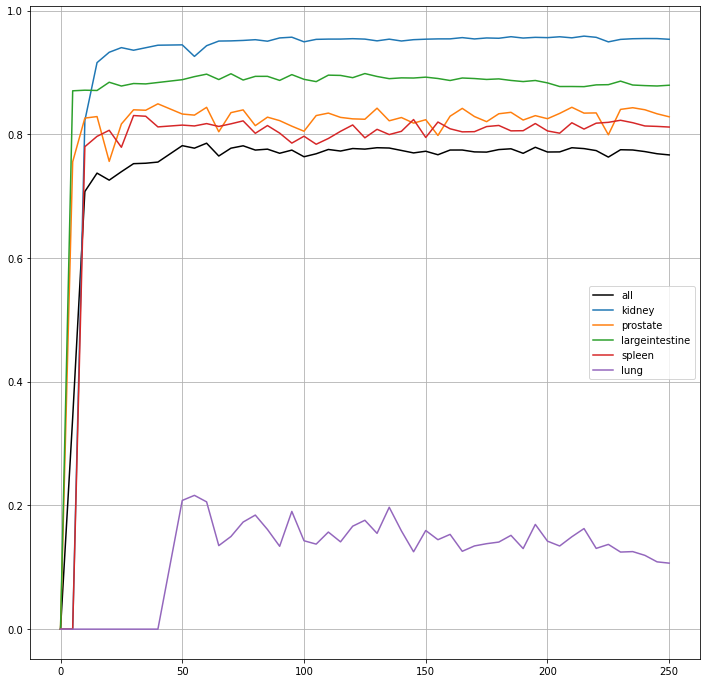

In [130]:
plt.figure(figsize=(12, 12))
plt.plot(epochs, mean_dices, color='black', label='all')
for key in organ_mean_dices.keys():
    plt.plot(epochs, organ_mean_dices[key], label=key)
    
plt.grid(which='both')
plt.legend()
plt.show()

In [131]:
train_df.shape

(351, 11)

In [132]:
from collections import Counter

In [135]:
Counter(train_df['organ'])

Counter({'prostate': 93,
         'spleen': 53,
         'lung': 48,
         'kidney': 99,
         'largeintestine': 58})